In [1]:
import numpy as np
import torch
from taker import Model
m = Model("google/gemma-2-2b-it")
# m = Model("microsoft/phi-3-mini-4k-instruct")

prompt = "<bos><start_of_turn>user\nWrite a story of a trip to Albania that inspired an interesting dish, followed by the recipe<end_of_turn>\n<start_of_turn>model\n"
story  = 'The scent of sun-baked rosemary, the tang of brine, and the earthy aroma of wild mushrooms filled the air as Elena stepped off the ferry in Vlorë.  She had dreamt of Albania for years, its ethereal mountains, turquoise waters, and rugged coastline calling to her like a siren song.  Her grandfather, a retired fisherman, had been the one who ignited her fascination, sharing stories of Albanian cuisine that danced on her tongue. He\'d called it "the food of the mountains," dishes bursting with fresh, local ingredients, a legacy passed down from generations.\n\nElena spent her days exploring the ancient ruins of Butrint, the glistening shores of the Albanian Riviera, and the bustling markets where vibrant colours and aromas painted a tapestry of life. But it was the humble village of Dhërmi, nestled amongst lush valleys and nestled against the glittering Adriatic Sea, that truly captivated her. \n\nIt was here, in the heart of a stone-built tavern, where she met Agim, a weathered farmer with eyes that held the wisdom of the mountains and a smile that warmed the sun.  He spoke of his grandmother\'s legendary recipe, "Pepa, the mountain\'s embrace."  It was a stew, he explained, that held the essence of the Albanian landscape, a symphony of flavours simmering in a pot. \n\nWith Agim\'s guidance, Elena\'s journey into the soul of Albanian cuisine began. He showed her how to gather wild mushrooms, the earthy aroma intoxicating, and how to choose plump pomegranates, their vibrant crimson staining her fingers. He taught her to layer the stew, a tapestry of potatoes, carrots, herbs, and the star of the show, the wild mushrooms, all bathed in rich tomato sauce.\n\nThe dish, "Pepa", was a revelation.  It was a celebration of the earth\'s bounty, its flavors as vibrant as the colours of the surrounding landscape. It was a reminder of the simple pleasures of life, of connection and community.\n\nElena\'s own version of "Pepa" became an ode to her Albanian adventure. \n\n'
recipe = '**Elena\'s "Pepa" (Mountain\'s Embrace)**\n\n**Ingredients:**\n\n* 1 tbsp olive oil\n* 1 large onion, chopped\n* 2 carrots, chopped\n* 2 large potatoes, peeled and cut into chunks\n* 1 lb wild mushrooms, cleaned and sliced\n* 1 tbsp tomato'

text = prompt+story+recipe

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded model 'google/gemma-2-2b-it' with bfp16:
- Added 416 hooks across 26 layers


51 [' wild mushrooms filled the air as Elena stepped off the']
88 [' her like a siren song.  Her grandfather,']
143 [' legacy passed down from generations.\n\nElena spent her']
180 [' painted a tapestry of life. But it was the']
250 [' smile that warmed the sun.  He spoke of']
299 [' simmering in a pot. \n\nWith Ag']
437 [", of connection and community.\n\nElena's"]
514 [' into chunks\n* 1 lb wild mushrooms,']


/tmp/ipykernel_1183614/2580112021.py:42: RuntimeWarning: Mean of empty slice.
  recency = subset.mean()
/workspace/nicky/taker/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

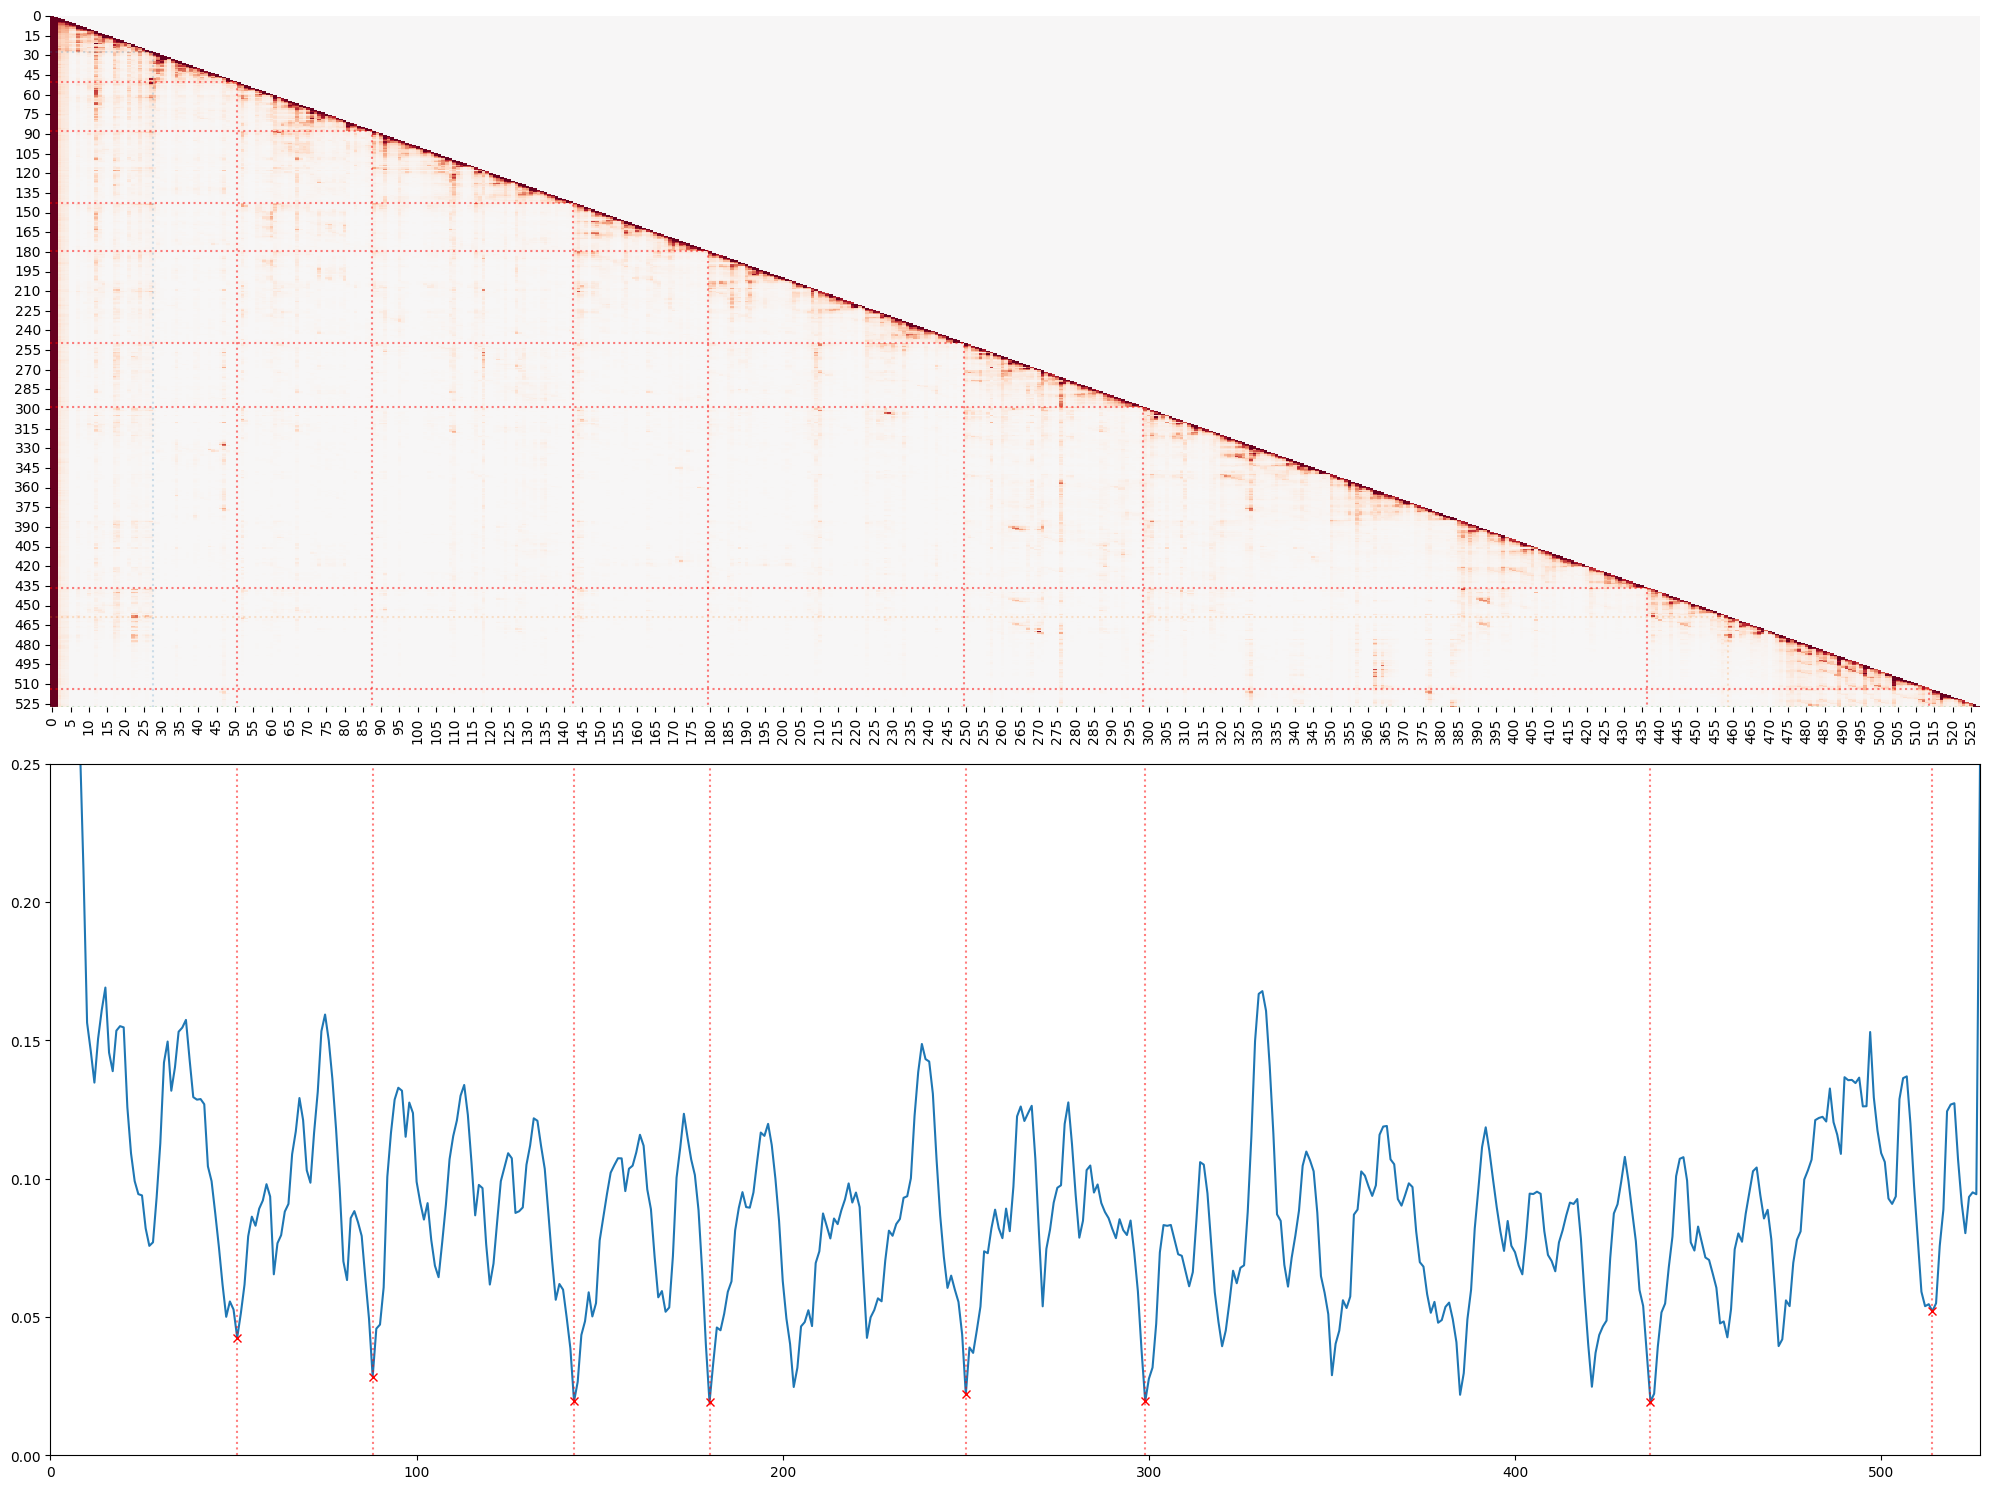

In [102]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def find_minimum_peaks(data, prominence=0.08):
    data = np.array(data)
    data = np.array([np.nan if isinstance(x, str) and x.lower() == 'nan' else float(x) for x in data])
    data = data[~np.isnan(data)]
    inverted_data = -1 * data
    peaks, properties = find_peaks(inverted_data, prominence=prominence)
    sorted_indices = np.argsort(properties['prominences'])[::-1]
    sorted_peaks = peaks[sorted_indices].astype(int)
    return sorted_peaks

with torch.no_grad():
    attn_weights = m.get_attn_weights(text)
    len1 = m.get_ids(prompt).shape[-1]
    len2 = m.get_ids(prompt+story).shape[-1]
    len3 = m.get_ids(prompt+story+recipe).shape[-1]
    ids = m.get_ids(prompt+story+recipe)[0]

    plt.figure()
    fig, axes = plt.subplots(2,1, figsize=(20,15))
    ax1 = axes[0]
    mean_weights = attn_weights[0].mean(dim=0).sum(dim=0).cpu().float().numpy()
    sns.heatmap(mean_weights, center=0.0, vmax=.5, vmin=0, cmap="RdBu_r", ax=ax1, cbar=False)
    for l in [len1, len2, len3]:
        ax1.plot((0, l, l), (l, l, len3), ":", alpha=0.2)

    # Try to find where there is "white squares" with little information back-reference
    ax2 = axes[1]
    scores = np.clip(mean_weights, a_min=0, a_max=0.5)
    recencies = []
    viewed = np.copy(mean_weights)
    for tok in range(len(scores)):
        window_min, window_max = 0, 8
        x_min, x_max = max([tok - window_max, 0]), max([tok - window_min, 0])
        y_min, y_max = min([tok + window_min, len(scores)-1]), min(tok + window_max, len(scores)-1)
        subset = scores[y_min:y_max, x_min:x_max]
        viewed[y_min:y_max, x_min:x_max] += 0.1
        recency = subset.mean()
        if np.isnan(recency):
            recency = scores[tok, tok] ** 2
        recencies.append(recency)
    ax2.plot(recencies)
    ax2.set_xlim(0, tok)
    ax2.set_ylim(0, sorted(recencies)[-10])

    # Find peaks in the original recencies data
    sorted_peaks = find_minimum_peaks(recencies, prominence=0.1)

    # Plot peaks on the original data
    ax2.plot(sorted_peaks, np.array(recencies)[sorted_peaks], "x", color='red')

    # Plot vertical lines for peaks
    for peak in sorted_peaks:
        ax2.plot((peak, peak, peak), (0, recencies[peak], ax2.get_ylim()[1]), ":", color='red', alpha=0.5)

    # Plot horizontal lines for peaks in ax1
    for peak in sorted_peaks:
        ax1.plot((0, peak, peak), (peak, peak, len3), ":", color='red', alpha=0.5)

    for peak in sorted(sorted_peaks):
        print(peak, m.tokenizer.batch_decode(ids[None, peak-5:peak+5]))

plt.tight_layout()
plt.show()

(0.0, 527.0)

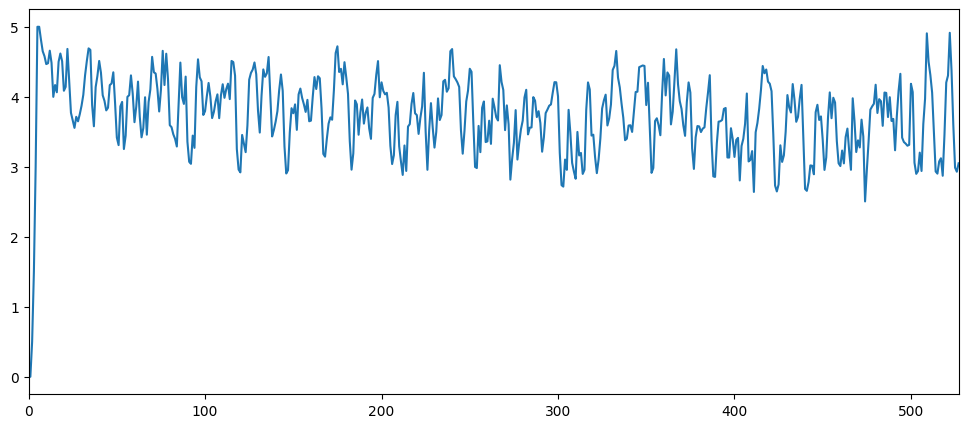

In [49]:
    # print(idx_min, tok, ":", recency)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(recencies)
plt.xlim(0, tok)

In [3]:
info_prompt = prompt+story
neutral_prompt = "<bos>\n\n"
acts = m.get_midlayer_activations(prompt+story)
orig_token_index = m.get_ids(prompt+story).shape[1] - 1
new_token_index  = m.get_ids(neutral_prompt).shape[1] - 1
max_new_tokens = 30
temperature = 0.1

#RESET HOOKS BEFORE TRANSPLANTING NEXT SET OF ACTIVATIONS
[h.reset() for h in m.hooks.neuron_replace.values()]

for layer_index in range(0,32):
    m.hooks.neuron_replace[f"layer_{layer_index}_mlp_pre_out"].add_token(new_token_index, acts["mlp"][0, layer_index, orig_token_index])
    m.hooks.neuron_replace[f"layer_{layer_index}_attn_pre_out"].add_token(new_token_index, acts["attn"][0, layer_index, orig_token_index])

for i in range(20):
    output = m.generate(neutral_prompt, 30, temperature=temperature)

    data = {
        "temperature": temperature,
        "max_new_tokens": max_new_tokens,
        "model": "microsoft/phi-3-mini-4k-instruct",
        "transplant_layers": (0,32),
        "orig_prompt": info_prompt,
        "transplant_prompt": neutral_prompt,
        "output": output[1],
    }

    print(data)

EinopsError:  Error while processing rearrange-reduction pattern "layer batch token n_heads d_head -> batch layer token n_heads d_head".
 Input tensor shape: torch.Size([26, 1, 459, 2048]). Additional info: {'n_heads': 8, 'd_head': 288}.
 Expected 5 dimensions, got 4